# Adversarial Image Captioning Attack

### Import Libraries, Set Seeds, and Select GPU

In [1]:
# Standard libraries
import json
import os

# Third party packages
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, ViTImageProcessor, VisionEncoderDecoderModel

# Reproducibility
np.random.seed(42)
torch.manual_seed(42)

c:\Users\Yoshio\OneDrive\Bildung\Master (CBS)\Semester-03\Advanced ML for NLP\final_project\Advanced-Machine-Learning-for-Natural-Language-Processing\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# GPU setup
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cpu


### Load COCO Mini Dataset

In [3]:
# Download dataset
data_path = kagglehub.dataset_download(
    "nagasai524/mini-coco2014-dataset-for-image-captioning")

In [4]:
def load_captions(dataset_path):
    """Load image_id -> list of captions mapping from captions.json."""
    captions_path = os.path.join(dataset_path, "captions.json")
    with open(captions_path, "r") as f:
        data = json.load(f)

    annotations = data["annotations"] if isinstance(data, dict) else data

    captions = {}
    for ann in annotations:
        img_id = ann["image_id"]
        captions.setdefault(img_id, []).append(ann["caption"])
    return captions

In [5]:
def find_image_folder(dataset_path, ext=".jpg"):
    """Find first folder under dataset_path that contains image files."""
    for root, _, files in os.walk(dataset_path):
        if any(f.lower().endswith(ext) for f in files):
            return root
    raise RuntimeError(f"No image folder with *{ext} found under {dataset_path}")

In [6]:
captions = load_captions(data_path)
img_folder = find_image_folder(data_path)
img_ids = sorted(captions.keys())

print(f"Dataset loaded, {len(img_ids)} images with captions")

Dataset loaded, 18783 images with captions


### Image Loading Helper

In [7]:
def get_image(idx):
    """Load image and its captions by index in img_ids."""
    img_id = img_ids[idx]

    # Try common filename patterns
    candidates = [
        os.path.join(img_folder, f"COCO_train2014_{img_id:012d}.jpg"),
        os.path.join(img_folder, f"{img_id}.jpg"),
    ]

    for img_path in candidates:
        if os.path.exists(img_path):
            img = Image.open(img_path).convert("RGB")
            return img, captions[img_id]

    raise FileNotFoundError(f"No image file found for image_id {img_id}")


### Visual Inspection of a Sample Image

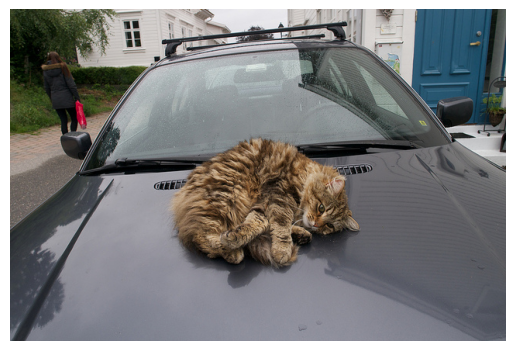

Image index: 6000, image_id: 190360
Ground truth captions:
  - A fluffy cat sleeping on the hood of a car
  - A cat is laying on a car parked in a road in front of houses with a person standing in the background
  - A cat is lying awake on a car hood
  - The cat is lying down on top of a black car
  - Cat relaxing on the hood of a car in an alley


In [8]:
# Choose an image to show
idx = 6000

img, caps = get_image(idx)

plt.imshow(img)
plt.axis("off")
plt.show()

print(f"Image index: {idx}, image_id: {img_ids[idx]}")
print("Ground truth captions:")
for cap in caps:
    print(f"  - {cap}")


### Load ViT-GPT2

In [9]:
model_name = "nlpconnect/vit-gpt2-image-captioning"

model = VisionEncoderDecoderModel.from_pretrained(
    model_name,
    attn_implementation="eager").to(device)

feature_extractor = ViTImageProcessor.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

model.eval()

print(f"Loaded model: {model_name}")
print(f"Decoder attention implementation: {model.config.decoder._attn_implementation}")

Loaded model: nlpconnect/vit-gpt2-image-captioning
Decoder attention implementation: eager


In [10]:
@torch.no_grad()
def generate_caption_and_attention(img, max_length=16):
    """
    Generate a caption for a PIL image and return:
    - caption (str)
    - cross_attentions (list of tensors)
    - encoder_hidden_states (tensor)
    """
    # Image -> pixel_values
    pixel_values = feature_extractor(images=img, return_tensors="pt").pixel_values.to(device)

    # Encode image
    encoder_outputs = model.encoder(pixel_values=pixel_values)
    encoder_hidden_states = encoder_outputs.last_hidden_state  # [1, 197, hidden_dim]

    # Generate caption ids
    generated_ids = model.generate(
        pixel_values,
        max_length=max_length,
        num_beams=1)

    # Run decoder once over full sequence to get cross-attentions
    decoder_outputs = model.decoder(
        input_ids=generated_ids,
        encoder_hidden_states=encoder_hidden_states,
        output_attentions=True,
        return_dict=True,
        use_cache=False)

    caption = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    return caption, decoder_outputs.cross_attentions, encoder_hidden_states


In [11]:
def aggregate_cross_attention(cross_attentions, img_size, patch_size=14):
    """
    Aggregate cross-attention over heads and tokens into a 2D heatmap
    in image resolution (sentence-based aggregation).
    
    cross_attentions: list of tensors, each [1, num_heads, tgt_len, src_len]
                      src_len = 1 (CLS) + patch_size^2
    img_size: (width, height) of the original image
    """
    # Take last decoder layer (most informative)
    last_layer = cross_attentions[-1]          # [1, num_heads, tgt_len, src_len]
    last_layer = last_layer.squeeze(0)         # [num_heads, tgt_len, src_len]

    # Average over heads and decoder tokens
    avg_over_heads = last_layer.mean(dim=0)    # [tgt_len, src_len]
    avg_over_tokens = avg_over_heads.mean(dim=0)  # [src_len]

    # Drop CLS token and keep only patch tokens
    patch_attention = avg_over_tokens[1:]      # [patch_size^2]

    # Reshape to patch grid
    attention_map = patch_attention.reshape(patch_size, patch_size).cpu().numpy()

    # Normalize to [0, 1]
    attention_map -= attention_map.min()
    denom = attention_map.max() if attention_map.max() > 0 else 1e-8
    attention_map /= denom

    # Upsample to original image size
    w, h = img_size
    attn_img = Image.fromarray((attention_map * 255).astype(np.uint8))
    attn_resized = attn_img.resize((w, h), resample=Image.BICUBIC)

    return np.array(attn_resized) / 255.0

In [12]:
def show_image_and_attention(img, caption, attention_heatmap):
    """Plot original image, attention heatmap, and overlay."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # 1) Original image
    axes[0].imshow(img)
    axes[0].set_title(f"Original image\nCaption: '{caption}'", fontsize=10)
    axes[0].axis("off")

    # 2) Heatmap only
    axes[1].imshow(attention_heatmap, cmap="hot")
    axes[1].set_title("Cross-attention heatmap\n(sentence-based)", fontsize=10)
    axes[1].axis("off")

    # 3) Overlay
    axes[2].imshow(img)
    axes[2].imshow(attention_heatmap, cmap="hot", alpha=0.5)
    axes[2].set_title("Attention overlay\n(red = high attention)", fontsize=10)
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()


### Load BLIP and add caption generation function

In [13]:
from transformers import BlipProcessor, BlipForConditionalGeneration

# Load BLIP
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained(
    "Salesforce/blip-image-captioning-base"
).to(device)
blip_model.eval()

print("BLIP model loaded!")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


BLIP model loaded!


In [14]:
@torch.no_grad()
def generate_blip_caption(img, max_length=20):
    """Generate caption using BLIP model"""
    inputs = blip_processor(img, return_tensors="pt").to(device)
    out = blip_model.generate(**inputs, max_length=max_length, num_beams=1)
    return blip_processor.decode(out[0], skip_special_tokens=True)

### Example: Pick an Image, Get Caption and Attention and Visualize

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


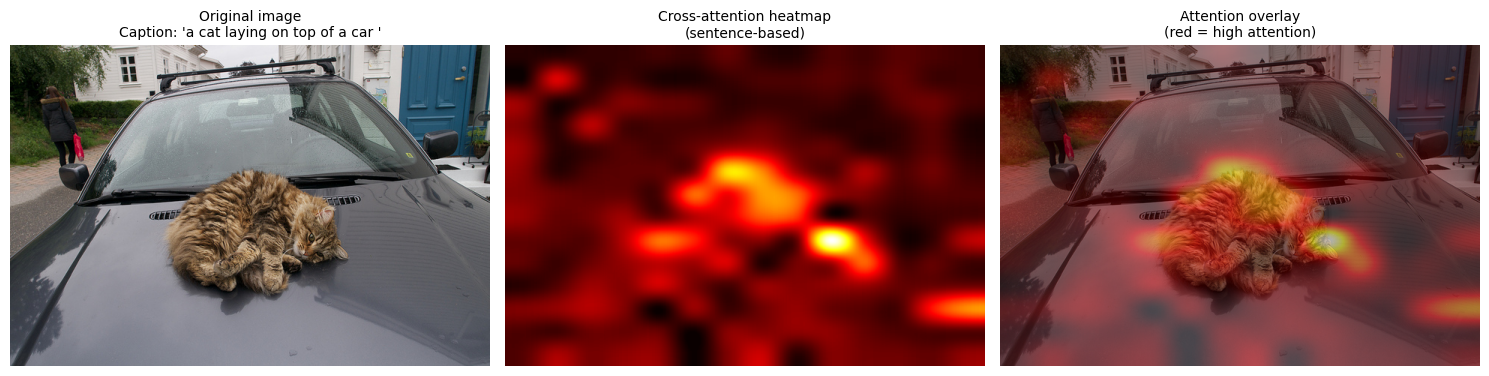

Image index: 6000, image_id: 190360

Ground-truth captions:
  - A fluffy cat sleeping on the hood of a car
  - A cat is laying on a car parked in a road in front of houses with a person standing in the background
  - A cat is lying awake on a car hood
  - The cat is lying down on top of a black car
  - Cat relaxing on the hood of a car in an alley


In [15]:
img, gt_caps = get_image(idx)

caption, cross_attentions, _ = generate_caption_and_attention(img)
attention_heatmap = aggregate_cross_attention(cross_attentions, img.size)

show_image_and_attention(img, caption, attention_heatmap)

print(f"Image index: {idx}, image_id: {img_ids[idx]}")
print("\nGround-truth captions:")
for cap in gt_caps:
    print(f"  - {cap}")

## Attack Pipeline

### Get the Candidate Mask

In [16]:
def get_topk_candidate_pixels(attention_heatmap, k):
    """
    Select top-k pixels with highest attention as candidate region.
    Returns list of (y, x) indices.
    """
    flat = attention_heatmap.flatten()
    k = min(k, flat.size)
    idxs = np.argpartition(flat, -k)[-k:]
    ys, xs = np.unravel_index(idxs, attention_heatmap.shape)
    return list(zip(ys, xs))


def show_candidate_region(img, attention_heatmap, candidate_pixels):
    """
    Visualize original image and candidate region (pixels we may perturb).
    """
    mask = np.zeros(attention_heatmap.shape, dtype=bool)
    for y, x in candidate_pixels:
        mask[y, x] = True

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Original image
    axes[0].imshow(img)
    axes[0].set_title("Original image")
    axes[0].axis("off")

    # Candidate overlay
    axes[1].imshow(img)
    axes[1].imshow(mask, cmap="Reds", alpha=0.6)
    axes[1].set_title("Candidate region (pixels we may perturb)")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

Attack Setup:
  Image index: 6000
  ViT-GPT2 caption: 'a cat laying on top of a car '
  BLIP caption: 'a cat sleeping on the hood of a car'
  Candidate pixels: 1500


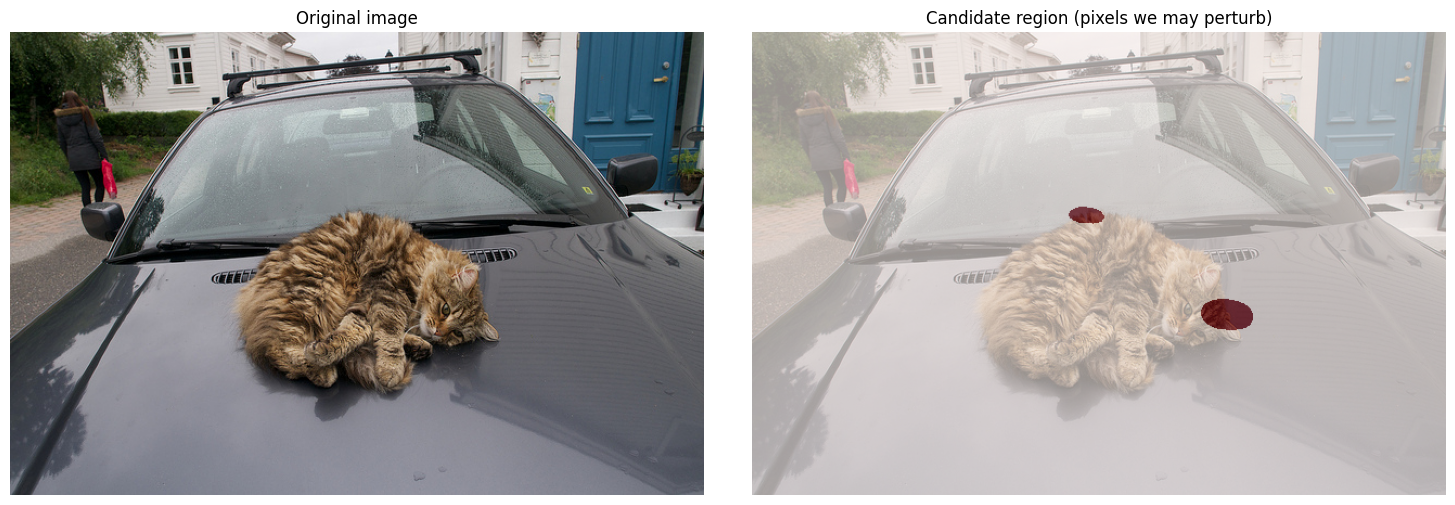

In [22]:
ATTACK_IDX = idx

# Load image
base_img, gt_caps = get_image(ATTACK_IDX)

# Get base captions from BOTH models
base_caption_vit, cross_attentions, _ = generate_caption_and_attention(base_img, max_length=16)
base_caption_blip = generate_blip_caption(base_img, max_length=16)

# Aggregate attention (sentence-based)
attention_heatmap = aggregate_cross_attention(cross_attentions, base_img.size)

# Select candidate pixels
TOPK_PIXELS = 1500
candidate_pixels = get_topk_candidate_pixels(attention_heatmap, k=TOPK_PIXELS)

print(f"Attack Setup:")
print(f"  Image index: {ATTACK_IDX}")
print(f"  ViT-GPT2 caption: '{base_caption_vit}'")
print(f"  BLIP caption: '{base_caption_blip}'")
print(f"  Candidate pixels: {len(candidate_pixels)}")

# Visualize candidate region
show_candidate_region(base_img, attention_heatmap, candidate_pixels)

In [23]:
def image_to_array(img):
    """Convert PIL image to uint8 numpy array of shape (H, W, 3)."""
    return np.array(img).astype(np.uint8)


def array_to_image(arr):
    """Convert numpy array (H, W, 3) back to PIL image."""
    return Image.fromarray(arr.astype(np.uint8))


def apply_perturbation(base_array, delta_vec, candidate_pixels):
    """
    Apply a perturbation vector to the candidate pixels of an image.
    
    base_array: numpy array (H, W, 3), uint8
    delta_vec: 1D numpy array of length 3 * len(candidate_pixels)
               [dR1, dG1, dB1, dR2, dG2, dB2, ...]
    candidate_pixels: list of (y, x) positions
    """
    H, W, C = base_array.shape
    assert C == 3, "Expected RGB image"
    num_pixels = len(candidate_pixels)
    assert delta_vec.shape[0] == 3 * num_pixels, "delta_vec length mismatch"

    # Work on a float copy so we can add positive/negative deltas
    perturbed = base_array.astype(np.float32).copy()
    deltas = delta_vec.reshape(num_pixels, 3)

    for (y, x), d in zip(candidate_pixels, deltas):
        # Add deltas to this pixel (R,G,B)
        perturbed[y, x, :] += d

    # Clip back to valid image range
    perturbed = np.clip(perturbed, 0, 255).astype(np.uint8)
    return array_to_image(perturbed)


# Base image as numpy array (used for all perturbations)
base_array = image_to_array(base_img)

print("Helper functions defined")

Helper functions defined


In [24]:
@torch.no_grad()
def generate_vit_caption(img, max_length=16):
    """Generate caption using ViT-GPT2"""
    pixel_values = feature_extractor(images=img, return_tensors="pt").pixel_values.to(device)
    generated_ids = model.generate(pixel_values, max_length=max_length, num_beams=1)
    return tokenizer.decode(generated_ids[0], skip_special_tokens=True)


@torch.no_grad()
def generate_blip_caption(img, max_length=16):
    """Generate caption using BLIP"""
    inputs = blip_processor(img, return_tensors="pt").to(device)
    out = blip_model.generate(**inputs, max_length=max_length, num_beams=1)
    return blip_processor.decode(out[0], skip_special_tokens=True)

print("Caption generation functions defined")

Caption generation functions defined


In [25]:
import nltk
try:
    nltk.data.find('tokenizers/punkt')
    print("NLTK punkt tokenizer already installed")
except LookupError:
    print("Installing NLTK punkt tokenizer...")
    nltk.download('punkt')
    print("Done!")

NLTK punkt tokenizer already installed


In [26]:
def differential_evolution(
    fitness_fn,
    dim,
    pop_size=30,
    generations=15,
    F=0.8,
    CR=0.9,
    eps=25.0,
    random_seed=42
):
    """
    Differential Evolution (DE/rand/1/bin).
    
    fitness_fn: function x -> scalar (higher = better)
    dim: dimensionality of x (here: 3 * len(candidate_pixels))
    pop_size: number of individuals in the population
    generations: number of DE generations
    F: mutation factor
    CR: crossover rate
    eps: perturbation bound: x ∈ [-eps, +eps]
    """
    rng = np.random.default_rng(random_seed)

    # 1) Initialize population with random vectors
    pop = rng.uniform(low=-eps, high=eps, size=(pop_size, dim)).astype(np.float32)
    fitness_vals = np.array([fitness_fn(ind) for ind in pop], dtype=np.float32)

    best_idx = int(np.argmax(fitness_vals))
    best_x = pop[best_idx].copy()
    best_f = float(fitness_vals[best_idx])

    print(f"Initial best fitness: {best_f:.4f}")

    # 2) Iterate over generations
    for gen in range(generations):
        print(f"\n--- Generation {gen + 1}/{generations} ---")

        for i in range(pop_size):
            # Choose indices for mutation (a, b, c all different and all != i)
            idxs = list(range(pop_size))
            idxs.remove(i)
            a, b, c = rng.choice(idxs, size=3, replace=False)

            x_a, x_b, x_c = pop[a], pop[b], pop[c]

            # Mutation: v = x_a + F * (x_b - x_c)
            v = x_a + F * (x_b - x_c)

            # Crossover: binomial
            cross_mask = rng.random(dim) < CR
            # Ensure at least one component comes from v
            j_rand = rng.integers(0, dim)
            cross_mask[j_rand] = True

            u = np.where(cross_mask, v, pop[i])
            
            # Clamp to bounds
            u = np.clip(u, -eps, eps)

            # Evaluate trial vector
            f_u = fitness_fn(u)

            # Selection: keep trial if it is better
            if f_u > fitness_vals[i]:
                pop[i] = u
                fitness_vals[i] = f_u

                # Update global best if necessary
                if f_u > best_f:
                    best_f = float(f_u)
                    best_x = u.copy()

        print(f"Best fitness after generation {gen + 1}: {best_f:.4f}")

    return best_x, best_f

print("Differential Evolution algorithm defined")

Differential Evolution algorithm defined


In [31]:
# Fitness function BLEU-based
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Attack parameters
EPS_BOUND = 100.0      # Paper standard
LAMBDA_REG = 0.005    # L2 penalty weight

# Dimension of search space
dim = 3 * len(candidate_pixels)

@torch.no_grad()
def fitness_bleu_vit(delta_vec):
    """
    Fitness function for attacking ViT-GPT2 using BLEU score.
    Lower BLEU = better attack.
    DE maximizes, so we return negative BLEU.
    """
    # Clamp perturbation
    delta = np.clip(delta_vec, -EPS_BOUND, EPS_BOUND)
    
    # Apply perturbation
    adv_img = apply_perturbation(base_array, delta, candidate_pixels)
    
    # Generate caption from ViT-GPT2 (our attack target)
    adv_caption = generate_vit_caption(adv_img, max_length=16)
    
    # Compute BLEU score against ViT-GPT2 base caption
    ref_tokens = [base_caption_vit.lower().split()]
    cand_tokens = adv_caption.lower().split()
    
    if len(cand_tokens) == 0:
        return -1.0  # Penalty for empty caption
    
    smoothing = SmoothingFunction().method1
    bleu = sentence_bleu(ref_tokens, cand_tokens, smoothing_function=smoothing)
    
    # L2 penalty for perturbation size
    l2_penalty = LAMBDA_REG * (np.linalg.norm(delta) / (255.0 * np.sqrt(len(delta))))
    
    # Return negative (DE maximizes, we want to minimize BLEU)
    return -(bleu + l2_penalty)

print(f"Fitness function defined")
print(f"  Search space dimension: {dim}")
print(f"  Epsilon bound: ±{EPS_BOUND}")
print(f"  Regularization: {LAMBDA_REG}")

# Quick test
print(f"\nTesting fitness function:")
x_zero = np.zeros(dim, dtype=np.float32)
f_zero = fitness_bleu_vit(x_zero)
print(f"  Fitness(zero perturbation): {f_zero:.4f}")

Fitness function defined
  Search space dimension: 4500
  Epsilon bound: ±100.0
  Regularization: 0.005

Testing fitness function:
  Fitness(zero perturbation): -1.0000


In [32]:
print("="*60)
print("SENTENCE-BASED ATTACK ON VIT-GPT2")
print("="*60)
print(f"Target model:     ViT-GPT2")
print(f"Aggregation:      Sentence-based")
print(f"Base caption:     '{base_caption_vit}'")
print(f"Candidate pixels: {len(candidate_pixels)}")
print(f"Epsilon bound:    {EPS_BOUND}")
print(f"Population size:  30")
print(f"Generations:      15")

# Run differential evolution
best_delta, best_fitness = differential_evolution(
    fitness_fn=fitness_bleu_vit,
    dim=dim,
    pop_size=30,
    generations=15,
    F=0.8,
    CR=0.9,
    eps=EPS_BOUND,
    random_seed=42
)

print(f"\n{'='*60}")
print(f"OPTIMIZATION COMPLETE")
print(f"{'='*60}")
print(f"Best fitness: {best_fitness:.4f}")

SENTENCE-BASED ATTACK ON VIT-GPT2
Target model:     ViT-GPT2
Aggregation:      Sentence-based
Base caption:     'a cat laying on top of a car '
Candidate pixels: 1500
Epsilon bound:    100.0
Population size:  30
Generations:      15
Initial best fitness: -1.0011

--- Generation 1/15 ---
Best fitness after generation 1: -1.0011

--- Generation 2/15 ---
Best fitness after generation 2: -1.0011

--- Generation 3/15 ---
Best fitness after generation 3: -1.0011

--- Generation 4/15 ---
Best fitness after generation 4: -1.0011

--- Generation 5/15 ---
Best fitness after generation 5: -1.0011

--- Generation 6/15 ---
Best fitness after generation 6: -1.0011

--- Generation 7/15 ---
Best fitness after generation 7: -1.0011

--- Generation 8/15 ---
Best fitness after generation 8: -1.0011

--- Generation 9/15 ---
Best fitness after generation 9: -1.0011

--- Generation 10/15 ---
Best fitness after generation 10: -1.0011

--- Generation 11/15 ---
Best fitness after generation 11: -1.0011

--- Ge

In [33]:
# Generate adversarial image
best_delta = np.clip(best_delta, -EPS_BOUND, EPS_BOUND)
adv_img = apply_perturbation(base_array, best_delta, candidate_pixels)

# Get captions from BOTH models
adv_caption_vit = generate_vit_caption(adv_img, max_length=16)
adv_caption_blip = generate_blip_caption(adv_img, max_length=16)

# Compute BLEU scores for both
smoothing = SmoothingFunction().method1

bleu_vit = sentence_bleu(
    [base_caption_vit.lower().split()],
    adv_caption_vit.lower().split(),
    smoothing_function=smoothing
)

bleu_blip = sentence_bleu(
    [base_caption_blip.lower().split()],
    adv_caption_blip.lower().split(),
    smoothing_function=smoothing
)

# Calculate BLEU decreases
bleu_decrease_vit = (1 - bleu_vit) * 100
bleu_decrease_blip = (1 - bleu_blip) * 100

# Transfer rate
transfer_rate = (bleu_decrease_blip / bleu_decrease_vit * 100) if bleu_decrease_vit > 0 else 0

# Perturbation statistics
delta_reshaped = best_delta.reshape(-1, 3)
per_pixel_linf = np.abs(delta_reshaped).max(axis=1)
avg_linf = per_pixel_linf.mean()
max_linf = per_pixel_linf.max()

total_pixels = base_array.shape[0] * base_array.shape[1]
epsilon_avg = len(candidate_pixels) * avg_linf / total_pixels

# Print results
print("\n" + "="*60)
print("ATTACK RESULTS")
print("="*60)

print("\n--- ViT-GPT2 (Attack Target) ---")
print(f"  Original caption:    '{base_caption_vit}'")
print(f"  Adversarial caption: '{adv_caption_vit}'")
print(f"  BLEU score:          {bleu_vit:.4f}")
print(f"  BLEU decrease:       {bleu_decrease_vit:.1f}%")
print(f"  Attack success:      {'✓ YES' if bleu_decrease_vit > 30 else '⚠ PARTIAL' if bleu_decrease_vit > 10 else '✗ NO'}")

print("\n--- BLIP (Transferability Test) ---")
print(f"  Original caption:    '{base_caption_blip}'")
print(f"  Adversarial caption: '{adv_caption_blip}'")
print(f"  BLEU score:          {bleu_blip:.4f}")
print(f"  BLEU decrease:       {bleu_decrease_blip:.1f}%")
print(f"  Transfer success:    {'✓ YES' if bleu_decrease_blip > 30 else '⚠ PARTIAL' if bleu_decrease_blip > 10 else '✗ NO'}")

print("\n--- Transferability Analysis ---")
print(f"  Transfer rate:       {transfer_rate:.1f}%")
print(f"  (Percentage of ViT-GPT2 attack that transfers to BLIP)")

print("\n--- Perturbation Statistics ---")
print(f"  Pixels perturbed:    {len(candidate_pixels)} / {total_pixels} ({len(candidate_pixels)/total_pixels*100:.1f}%)")
print(f"  Avg L∞ per pixel:    {avg_linf:.2f}")
print(f"  Max L∞ per pixel:    {max_linf:.2f}")
print(f"  ε (paper metric):    {epsilon_avg:.2f}")

print("\n" + "="*60)


ATTACK RESULTS

--- ViT-GPT2 (Attack Target) ---
  Original caption:    'a cat laying on top of a car '
  Adversarial caption: 'a cat laying on top of a car '
  BLEU score:          1.0000
  BLEU decrease:       0.0%
  Attack success:      ✗ NO

--- BLIP (Transferability Test) ---
  Original caption:    'a cat sleeping on the hood of a car'
  Adversarial caption: 'a cat sleeping on the hood of a car'
  BLEU score:          1.0000
  BLEU decrease:       0.0%
  Transfer success:    ✗ NO

--- Transferability Analysis ---
  Transfer rate:       0.0%
  (Percentage of ViT-GPT2 attack that transfers to BLIP)

--- Perturbation Statistics ---
  Pixels perturbed:    1500 / 273920 (0.5%)
  Avg L∞ per pixel:    74.83
  Max L∞ per pixel:    100.00
  ε (paper metric):    0.41



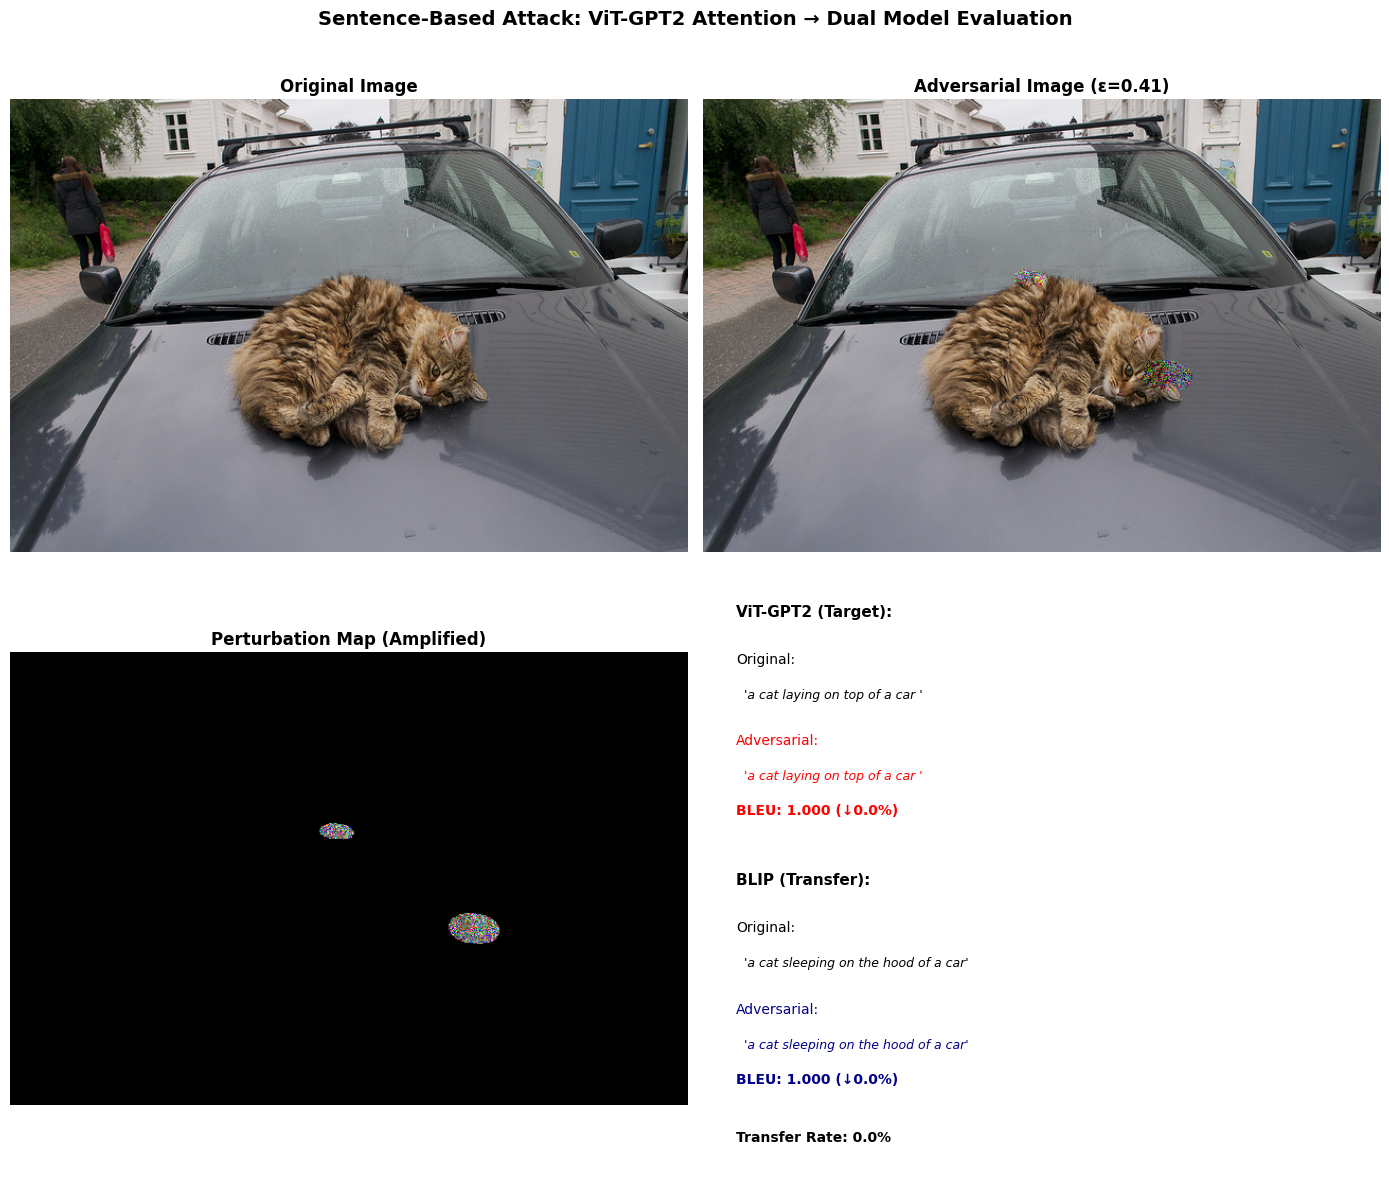

In [34]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Row 1, Col 1: Original image
axes[0, 0].imshow(base_img)
axes[0, 0].set_title(f"Original Image", fontsize=12, weight='bold')
axes[0, 0].axis("off")

# Row 1, Col 2: Adversarial image
axes[0, 1].imshow(adv_img)
axes[0, 1].set_title(f"Adversarial Image (ε={epsilon_avg:.2f})", fontsize=12, weight='bold')
axes[0, 1].axis("off")

# Row 2, Col 1: Perturbation visualization
diff = np.abs(np.array(adv_img).astype(float) - np.array(base_img).astype(float))
diff_normalized = diff / diff.max() if diff.max() > 0 else diff
axes[1, 0].imshow(diff_normalized)
axes[1, 0].set_title("Perturbation Map (Amplified)", fontsize=12, weight='bold')
axes[1, 0].axis("off")

# Row 2, Col 2: Text comparison
axes[1, 1].axis("off")
text_y = 0.95

# ViT-GPT2 results
axes[1, 1].text(0.05, text_y, "ViT-GPT2 (Target):", fontsize=11, weight='bold',
                transform=axes[1, 1].transAxes)
text_y -= 0.08
axes[1, 1].text(0.05, text_y, f"Original:", fontsize=10,
                transform=axes[1, 1].transAxes)
text_y -= 0.06
axes[1, 1].text(0.05, text_y, f"  '{base_caption_vit}'", fontsize=9, style='italic',
                transform=axes[1, 1].transAxes, wrap=True)
text_y -= 0.08
axes[1, 1].text(0.05, text_y, f"Adversarial:", fontsize=10, color='red',
                transform=axes[1, 1].transAxes)
text_y -= 0.06
axes[1, 1].text(0.05, text_y, f"  '{adv_caption_vit}'", fontsize=9, style='italic',
                color='red', transform=axes[1, 1].transAxes, wrap=True)
text_y -= 0.06
axes[1, 1].text(0.05, text_y, f"BLEU: {bleu_vit:.3f} (↓{bleu_decrease_vit:.1f}%)", 
                fontsize=10, weight='bold', color='red',
                transform=axes[1, 1].transAxes)

text_y -= 0.12

# BLIP results
axes[1, 1].text(0.05, text_y, "BLIP (Transfer):", fontsize=11, weight='bold',
                transform=axes[1, 1].transAxes)
text_y -= 0.08
axes[1, 1].text(0.05, text_y, f"Original:", fontsize=10,
                transform=axes[1, 1].transAxes)
text_y -= 0.06
axes[1, 1].text(0.05, text_y, f"  '{base_caption_blip}'", fontsize=9, style='italic',
                transform=axes[1, 1].transAxes, wrap=True)
text_y -= 0.08
axes[1, 1].text(0.05, text_y, f"Adversarial:", fontsize=10, color='darkblue',
                transform=axes[1, 1].transAxes)
text_y -= 0.06
axes[1, 1].text(0.05, text_y, f"  '{adv_caption_blip}'", fontsize=9, style='italic',
                color='darkblue', transform=axes[1, 1].transAxes, wrap=True)
text_y -= 0.06
axes[1, 1].text(0.05, text_y, f"BLEU: {bleu_blip:.3f} (↓{bleu_decrease_blip:.1f}%)", 
                fontsize=10, weight='bold', color='darkblue',
                transform=axes[1, 1].transAxes)

text_y -= 0.10
axes[1, 1].text(0.05, text_y, f"Transfer Rate: {transfer_rate:.1f}%", 
                fontsize=10, weight='bold',
                transform=axes[1, 1].transAxes)

plt.suptitle(f"Sentence-Based Attack: ViT-GPT2 Attention → Dual Model Evaluation", 
             fontsize=14, weight='bold', y=0.98)
plt.tight_layout()
plt.show()